In [6]:
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer


model_name = "google-t5/t5-base"

tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [13]:
from transformers import AutoTokenizer, AutoModelForCausalLM
t5_model_name = "google-t5/t5-base"
gpt_model_name = "openai-community/gpt2"
bert_model_name = "google-bert/bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
model = AutoModelForCausalLM.from_pretrained(gpt_model_name)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [16]:
from datasets import Dataset
from transformers import TrainingArguments
import evaluate


dataset = Dataset.load_from_disk('reduced_dataset')
dataset = dataset.train_test_split(test_size=0.2, train_size=0.7)

training_args = TrainingArguments(output_dir="test_trainer")
metric = evaluate.load("f1")


In [19]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 8897
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 2542
    })
})

In [17]:
import numpy as np
import nltk
from transformers import TrainingArguments, Trainer

prefix = "answer the question: "

def preprocess_function(examples):
    """Add prefix to the sentences, tokenize the text, and set the labels"""
    # The "inputs" are the tokenized answer:
    inputs = [prefix + doc for doc in examples["question"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)
    
    # The "labels" are the tokenized outputs:
    labels = tokenizer(text_target=examples["answer"], max_length=512, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Set up Rouge score for evaluation
nltk.download("punkt", quiet=True)
metric = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # decode preds and labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # rougeLSum expects newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return result

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

tokenized_dataset = dataset.map(preprocess_function, batched=True)

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True,
    push_to_hub=False
)

# Set up trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model

Map:   0%|          | 0/8897 [00:00<?, ? examples/s]

Map:   0%|          | 0/2542 [00:00<?, ? examples/s]

/home/a/miniforge3/envs/nlp_/lib/python3.8/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
trainer.evaluate()


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/home/a/miniforge3/envs/nlp_/lib/python3.8/site-packages/transformers/generation/utils.py:1259: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


ValueError: Input length of input_ids is 31, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.

In [2]:
from transformers import AutoModel

# Get a list of all available models
all_models = AutoModel.list(library="huggingface/transformers")

# Print the model names
for model in all_models:
    print(model["name"])
		

AttributeError: type object 'AutoModel' has no attribute 'list'

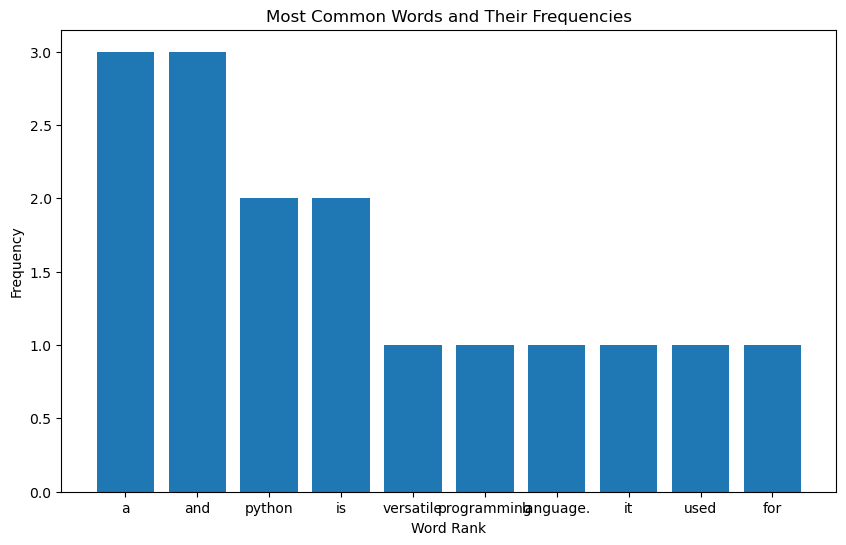

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

# Sample text data
text = """
Python is a versatile programming language.
It is used for web development, data analysis, and machine learning.
Python has a large community and a rich ecosystem of libraries and frameworks.
"""

# Tokenize the text and calculate word frequencies
words = text.lower().split()
word_freq = Counter(words)

# Get the most common words and their frequencies
num_words = 10
most_common_words = word_freq.most_common(num_words)

# Plot the word frequencies
plt.figure(figsize=(10, 6))
plt.bar(range(num_words), [freq for word, freq in most_common_words])
plt.xlabel("Word Rank")
plt.ylabel("Frequency")
plt.title("Most Common Words and Their Frequencies")
plt.xticks(range(num_words), [word for word, freq in most_common_words])
plt.show()

In [20]:
import nltk

informative_words = 

informative_words

['python',
 'programming',
 'language.',
 'development,',
 'data',
 'analysis,',
 'machine',
 'learning.',
 'python',
 'community',
 'ecosystem',
 'libraries',
 'frameworks.']